In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [2]:
# Chemin du dossier contenant les images
image_root = './archive/Train'  # Chemin relatif vers les images

# Liste pour stocker les données
data = []

# Parcourir les sous-dossiers (chaque sous-dossier représente une classe)
for class_id, class_name in enumerate(os.listdir(image_root)):
    class_dir = os.path.join(image_root, class_name)
    
    # Vérifier que c'est un dossier
    if os.path.isdir(class_dir):
        # Parcourir les images dans le dossier de la classe
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_name, image_name)  # Chemin relatif de l'image
            data.append({'Path': image_path, 'ClassId': class_id})

# Créer un DataFrame à partir des données
df = pd.DataFrame(data)

# Sauvegarder le DataFrame en CSV
output_csv = './archive/image_labels.csv'
df.to_csv(output_csv, index=False)

print(f"Fichier CSV créé avec succès : {output_csv}")

Fichier CSV créé avec succès : ./archive/image_labels.csv


In [4]:
import os

img_path = "C:/Users/pc/Desktop/Twizzy/archive/Train/4/4_00004_00022_00021.png"  # Utilise le chemin complet
print(os.path.exists(img_path))  # Cela retournera True si le fichier existe, sinon False


True


In [8]:

# Charger le fichier CSV
train_csv = './archive/image_labels.csv'
train_labels = pd.read_csv(train_csv)

# Transformation des images (si nécessaire)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Créer un dataset personnalisé
class ImageDataset(Dataset):
    def __init__(self, root, labels, transform=None):
        self.root = root
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.labels.iloc[idx]['Path'])
        image = Image.open(img_path).convert('RGB')  # Ouvrir l'image et la convertir en RGB
        label = self.labels.iloc[idx]['ClassId']  # Récupérer l'étiquette

        if self.transform:
            image = self.transform(image)  # Appliquer les transformations (si présentes)

        return image, label

# Créer le dataset
train_dataset = ImageDataset(image_root, train_labels, transform=transform)

# Créer le DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Vérifier les premières lignes du DataFrame des labels
print(train_labels)

# Vérifier si le DataLoader fonctionne
for images, labels in train_loader:
    print('Dimensions des images dans le batch:', images.shape)
    print('Dimensions des labels dans le batch:', labels.shape)
    break
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output, 1)  # Récupérer les indices des classes prédites
    correct = (predicted == labels).sum().item()  # Comparer les prédictions aux étiquettes
    accuracy = 100 * correct / labels.size(0)  # Calculer la précision en pourcentage
    return accuracy

                           Path  ClassId
0     1\1_00001_00000_00000.png        0
1     1\1_00001_00000_00001.png        0
2     1\1_00001_00000_00002.png        0
3     1\1_00001_00000_00003.png        0
4     1\1_00001_00000_00004.png        0
...                         ...      ...
4527      8\8_Screenshot_55.png        7
4528       8\8_Screenshot_6.png        7
4529       8\8_Screenshot_7.png        7
4530       8\8_Screenshot_8.png        7
4531       8\8_Screenshot_9.png        7

[4532 rows x 2 columns]
Dimensions des images dans le batch: torch.Size([128, 3, 64, 64])
Dimensions des labels dans le batch: torch.Size([128])


In [ ]:
import pandas as pd

# Afficher toutes les lignes du DataFrame
pd.set_option('display.max_rows', None)  # Affiche toutes les lignes
print(train_labels)


In [10]:
def train_model(model, num_epochs, train_loader, valid_loader, test_loader, optimizer, device, scheduler, scheduler_on='valid_acc', logging_interval=100):
    train_acc_list = []
    valid_acc_list = []
    minibatch_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Entraînement
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calcul de la précision
            accuracy = calculate_accuracy(outputs, labels)
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += labels.size(0)
            
            if i % logging_interval == logging_interval - 1:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / logging_interval:.4f}')
                running_loss = 0.0
        
        train_accuracy = 100 * correct_train / total_train
        train_acc_list.append(train_accuracy)

        # Validation
        model.eval()
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                
                # Calcul de la précision pour la validation
                accuracy = calculate_accuracy(outputs, labels)
                correct_valid += (outputs.argmax(dim=1) == labels).sum().item()
                total_valid += labels.size(0)
        
        valid_accuracy = 100 * correct_valid / total_valid
        valid_acc_list.append(valid_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%')

        # Scheduler
        if scheduler_on == 'valid_acc':
            scheduler.step(valid_accuracy)
        
    return minibatch_loss_list, train_acc_list, valid_acc_list

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=8):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Train Accuracy: 55.25%, Valid Accuracy: 47.22%
Epoch [2/10], Train Accuracy: 82.57%, Valid Accuracy: 90.86%
Epoch [3/10], Train Accuracy: 94.24%, Valid Accuracy: 96.16%
Epoch [4/10], Train Accuracy: 97.57%, Valid Accuracy: 95.83%
Epoch [5/10], Train Accuracy: 98.12%, Valid Accuracy: 99.36%
Epoch [6/10], Train Accuracy: 98.83%, Valid Accuracy: 96.93%
Epoch [7/10], Train Accuracy: 99.25%, Valid Accuracy: 99.45%
Epoch [8/10], Train Accuracy: 99.51%, Valid Accuracy: 99.78%
Epoch [9/10], Train Accuracy: 99.96%, Valid Accuracy: 100.00%
Epoch [10/10], Train Accuracy: 99.98%, Valid Accuracy: 100.00%


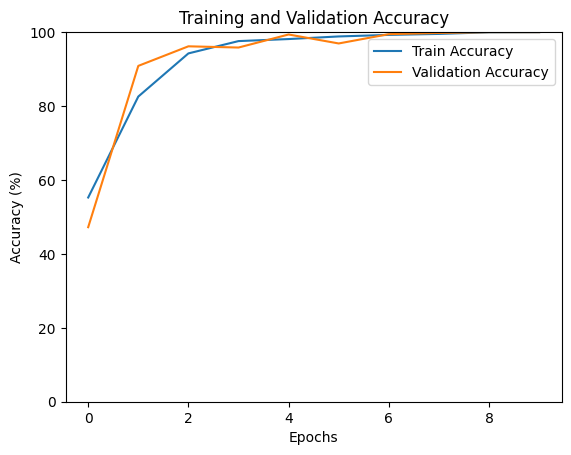

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=8)  # ResNet34
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

# Variables d'entraînement
NUM_EPOCHS = 10

# Charger les DataLoader pour la validation et le test (ajouter ces datasets comme vous le souhaitez)
valid_loader = train_loader  # Utilisez un valid_loader approprié
test_loader = train_loader   # Utilisez un test_loader approprié

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

# Affichage des courbes de précision
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(valid_acc_list, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 100])
plt.show()

In [31]:
# Sauvegarder l'état du modèle et de l'optimiseur
MODEL_PATH = './model_resnet4_classes.pth'

# Sauvegarder l'état du modèle
torch.save(model.state_dict(), MODEL_PATH)

# Si vous voulez aussi sauvegarder l'optimiseur
OPTIMIZER_PATH = './optimizer_resnet4_classes.pth'
torch.save(optimizer.state_dict(), OPTIMIZER_PATH)

print(f"Modèle et optimiseur sauvegardés avec succès dans {MODEL_PATH} et {OPTIMIZER_PATH}")


Modèle et optimiseur sauvegardés avec succès dans ./model_resnet4_classes.pth et ./optimizer_resnet4_classes.pth


In [30]:
# Charger le modèle et l'optimiseur sauvegardés
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=8)  # Assurez-vous d'utiliser la même architecture
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))

print(f"Modèle et optimiseur chargés avec succès depuis {MODEL_PATH} et {OPTIMIZER_PATH}")


Modèle et optimiseur chargés avec succès depuis ./model_resnet4_classes.pth et ./optimizer_resnet4_classes.pth


In [28]:


# Mode évaluation (désactive le dropout, batchnorm)
model.eval()

# Exemple d'utilisation pour une image de test
test_image_path = './archive/Test/Screenshot_45.png'
test_image = Image.open(test_image_path).convert('RGB')

# Appliquer les transformations
test_image = transform(test_image).unsqueeze(0).to(DEVICE)

# Effectuer la prédiction
with torch.no_grad():  # Désactive le calcul de gradients pour l'inférence
    output = model(test_image)
    _, predicted_class = torch.max(output, 1)

# Dictionnaire des correspondances classe -> vitesse
speed_limits = {
    0: "30 km/h",
    1: "Stop",
    2: "50 km/h",
    3: "70 km/h",
    4: "80 km/h",
    6: "110 km/h",
    5: "90 km/h" ,
    7: "130mn/h"

}

# Récupérer la vitesse correspondante
predicted_speed = speed_limits.get(predicted_class.item(), "Classe inconnue")

print(f'Classe prédite : {predicted_class.item()} - Vitesse associée : {predicted_speed}')



Classe prédite : 6 - Vitesse associée : 110 km/h
